In [1]:
# Ignorer les avertissements pour améliorer la lisibilité du code
import warnings
warnings.filterwarnings('ignore')

Importation des bibliothèques

In [2]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer

Fonction pour Charger un Fichier JSON

In [3]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = 'intents.json'

intents = load_json_file(filename)

Création d'un DataFrame Pandas Vide

In [4]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })
    
    return df

df = create_df()
df

,Pattern,Tag


Extraction d'Informations depuis un Fichier JSON vers un DataFrame

In [5]:
def extract_json_info(json_file, df):
    
    for intent in json_file['intents']:
        
        for pattern in intent['patterns']:
            
            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag
                
    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting


Copie du DataFrame

In [6]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting


Fonction pour Afficher les Dimensions d'un DataFrame

In [7]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")
    
print_shape_df(df, "Chatbot")

Chatbot dataset has 232 rows and 2 columns


Fonction pour Afficher les Informations d'un DataFrame

In [8]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())
    
print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  232 non-null    object
 1   Tag      232 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB
None


Fonction pour Compter le Nombre de Classes dans une Colonne

In [9]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")
    
num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 80 classes


 Fonction pour Vérifier les Valeurs Nulles dans un DataFrame

In [10]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())
    
check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


Fonction pour Tracer un Graphique à Barres

In [11]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order=None, rotation=False, palette='winter', hue=None):
    # Calcul du nombre total de données dans le DataFrame
    ncount = len(df)
    
    # Création de la figure avec la taille spécifiée
    plt.figure(figsize=(width, height))
    
    # Utilisation de Seaborn pour créer le graphique à barres
    ax = sns.countplot(x=x, data=df, palette=palette, order=order, hue=hue)
    
    # Ajout du titre et ajustement de la taille des étiquettes
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation='vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    # Positionnement de l'étiquette de l'axe des y à gauche
    ax.yaxis.set_label_position('left')
    
    # Ajout d'annotations pour indiquer les pourcentages au-dessus des barres
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate('{:.1f}%'.format(100. * y / ncount), (x.mean(), y),
                    ha='center', va='bottom')  # alignement du texte

    # Affichage du graphique
    plt.show()


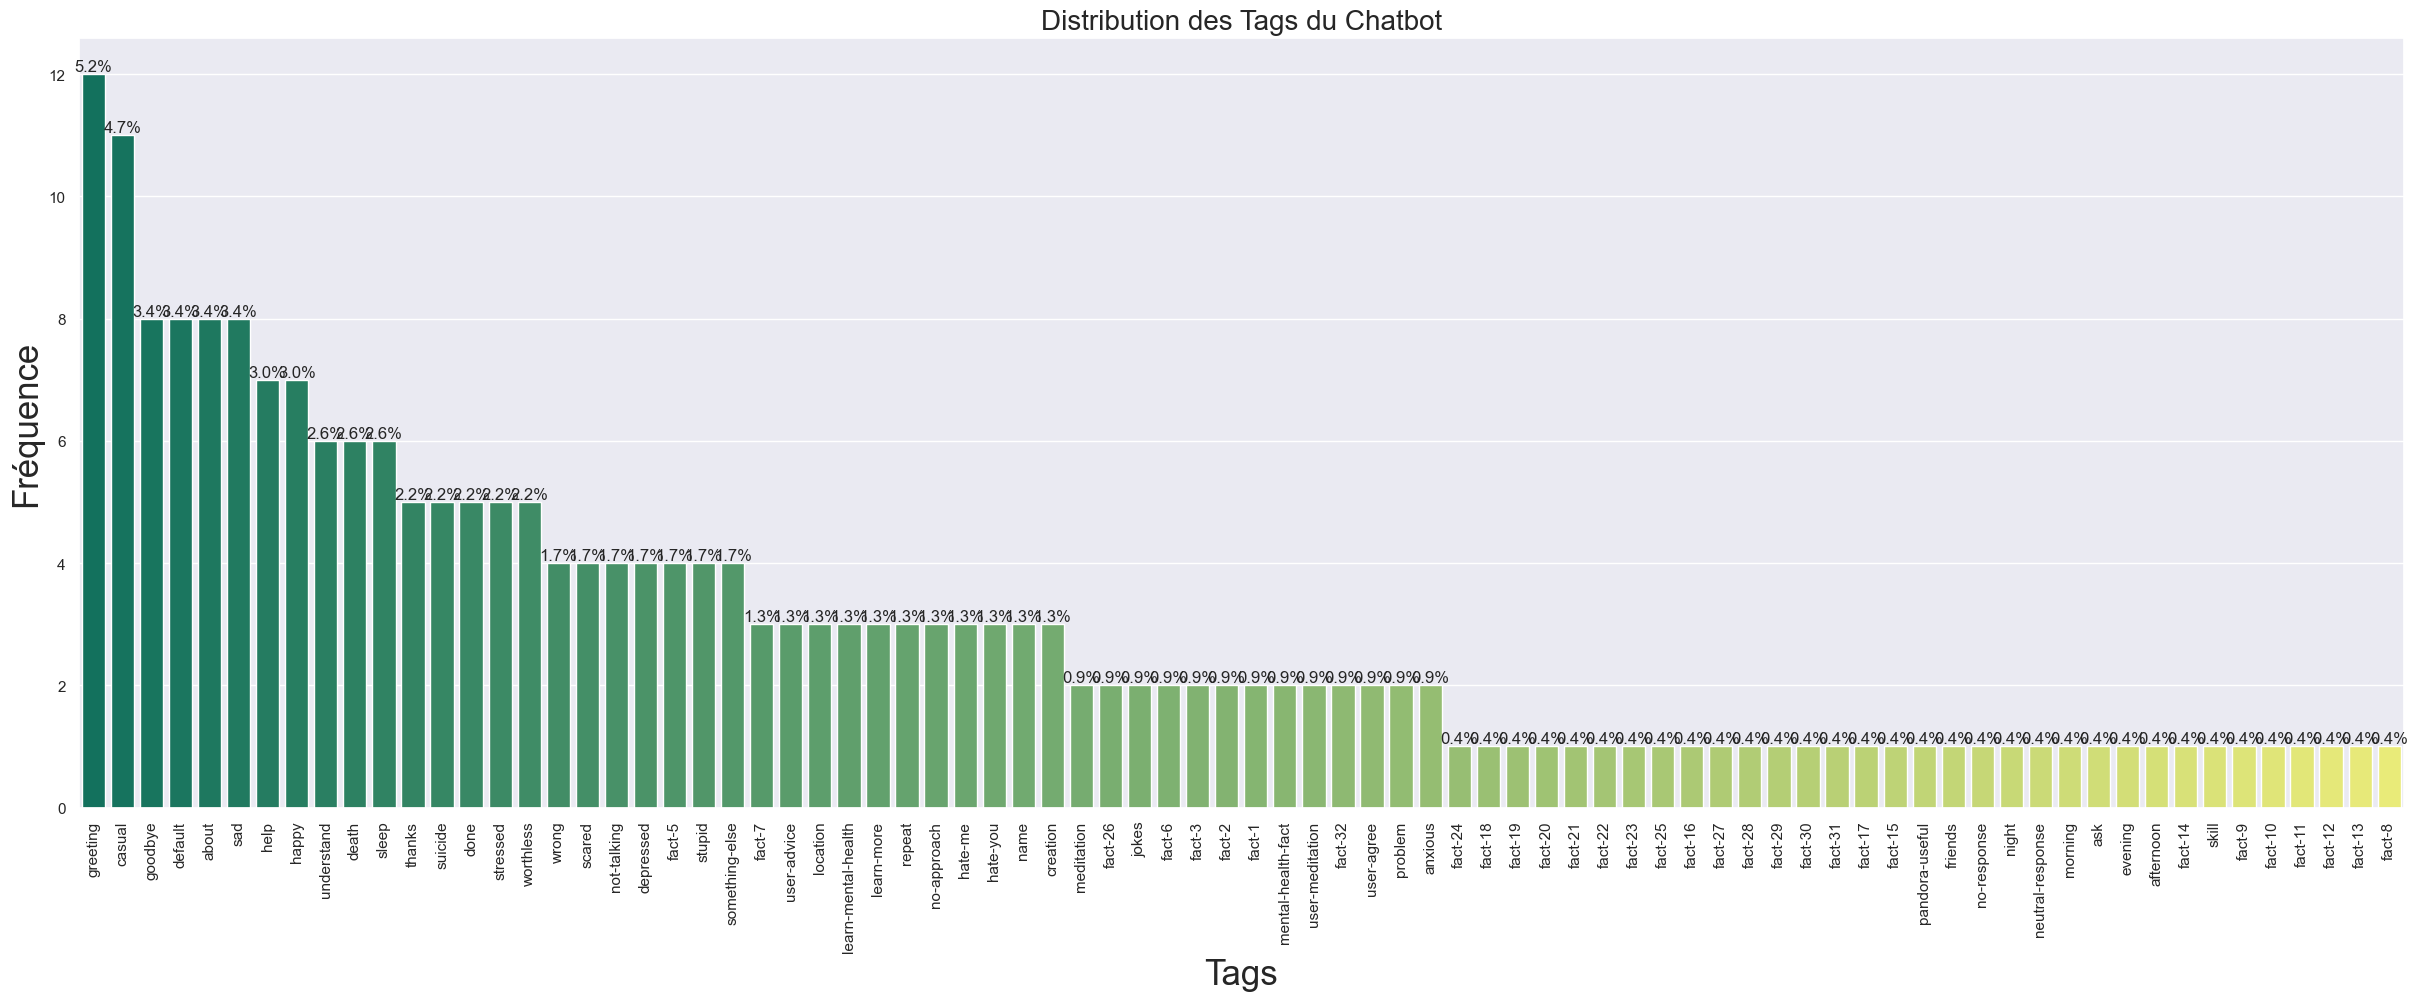

In [12]:
# Ajustement de la taille de police de Seaborn
sns.set(font_scale=1)

# Définition de l'ordre des catégories en fonction de leur fréquence
order = df['Tag'].value_counts().index

# Utilisation de la fonction count_plot pour tracer le graphique à barres
count_plot(df['Tag'], df, "Distribution des Tags du Chatbot", "Tags", "Fréquence", 30, 10, order=order, rotation=True, palette="summer")

Prétraitement du Texte avec NLTK Stemming

In [13]:
# Initialisation du stemmer
stemmer = PorterStemmer()

# Liste des mots à ignorer lors du prétraitement
ignore_words = ['?', '!', ',', '.']

# Fonction pour prétraiter un motif en le convertissant en minuscules, en le tokenisant et en appliquant le stemming
def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

# Application du prétraitement à la colonne 'Pattern' du DataFrame
df['Pattern'] = df['Pattern'].apply(preprocess_pattern)


In [14]:
df.head()

,Pattern,Tag
0,hi,greeting
1,hey,greeting
2,is anyon there,greeting
3,hi there,greeting
4,hello,greeting


In [15]:
# Affichage du nombre de valeurs nulles dans la colonne 'Pattern'
print(df['Pattern'].isnull().sum())

0


Visualisation du Nuage de Mots avec WordCloud

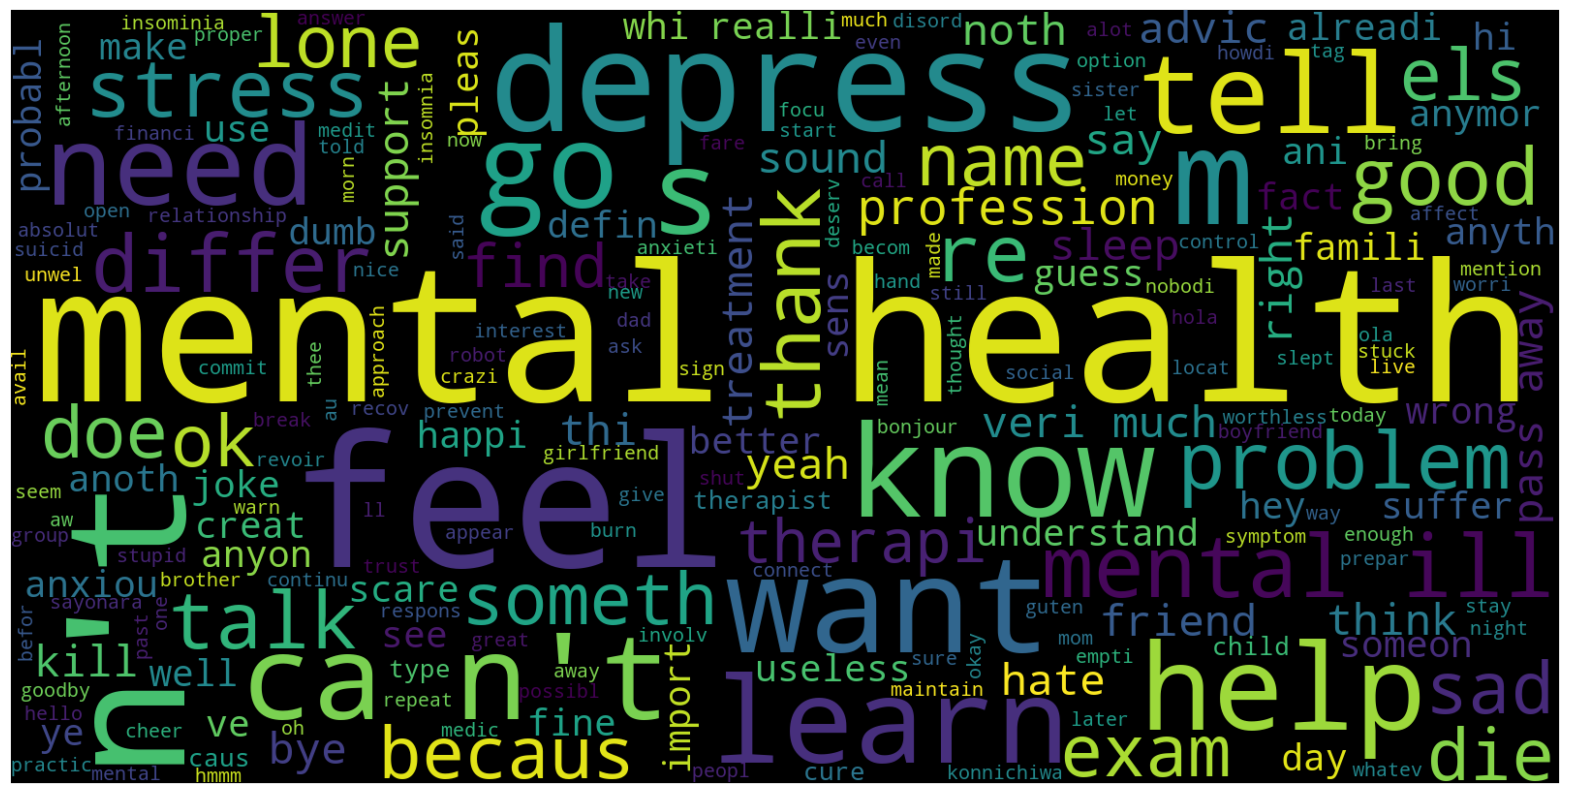

In [16]:
# Création d'une figure avec une taille spécifiée
plt.figure(figsize=(20, 20))

# Génération du WordCloud à partir des motifs dans la colonne 'Pattern'
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))

# Affichage du WordCloud avec interpolation bilinéaire
plt.imshow(wc, interpolation='bilinear')

# Désactivation des étiquettes sur les axes
plt.xticks([])
plt.yticks([])

# Affichage du WordCloud généré
plt.show()


Extraction du Corpus à partir de la Colonne 'Pattern'

In [17]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

# Appel de la fonction pour extraire le corpus de la colonne 'Pattern'
corpus = get_corpus(df.Pattern)

# Affichage des cinq premiers éléments du corpus
corpus[:5]

['hi', 'hey', 'is', 'anyon', 'there']

In [18]:
# Affichage du nombre total de mots dans le corpus
print(f"Le dataset contient {len(corpus)} mots")

Le dataset contient 1075 mots


Identification des Mots les Plus Fréquents dans le Corpus

In [19]:
from collections import Counter

# Utilisation de Counter pour compter les occurrences de chaque mot dans le corpus
counter = Counter(corpus)

# Extraction des dix mots les plus fréquents sous forme de dictionnaire
most_common = dict(counter.most_common(10))

# Affichage des mots les plus fréquents
most_common

{'i': 107,
 'you': 43,
 'what': 32,
 'mental': 26,
 'do': 25,
 'to': 24,
 "n't": 21,
 'about': 20,
 'me': 19,
 'health': 19}

In [20]:
df2.head()

,Pattern,Tag
0,Hi,greeting
1,Hey,greeting
2,Is anyone there?,greeting
3,Hi there,greeting
4,Hello,greeting


Extraction des Libellés Uniques de la Colonne 'Tag'

In [21]:
# Extraction des libellés uniques de la colonne 'Tag' du DataFrame
labels = df2['Tag'].unique().tolist()

# Nettoyage des espaces autour des libellés
labels = [s.strip() for s in labels]

# Affichage des libellés après nettoyage
labels

['greeting',
 'morning',
 'afternoon',
 'evening',
 'night',
 'goodbye',
 'thanks',
 'no-response',
 'neutral-response',
 'about',
 'skill',
 'creation',
 'name',
 'help',
 'sad',
 'stressed',
 'worthless',
 'depressed',
 'happy',
 'casual',
 'anxious',
 'not-talking',
 'sleep',
 'scared',
 'death',
 'understand',
 'done',
 'suicide',
 'hate-you',
 'hate-me',
 'default',
 'jokes',
 'repeat',
 'wrong',
 'stupid',
 'location',
 'something-else',
 'friends',
 'ask',
 'problem',
 'no-approach',
 'learn-more',
 'user-agree',
 'meditation',
 'user-meditation',
 'pandora-useful',
 'user-advice',
 'learn-mental-health',
 'mental-health-fact',
 'fact-1',
 'fact-2',
 'fact-3',
 'fact-5',
 'fact-6',
 'fact-7',
 'fact-8',
 'fact-9',
 'fact-10',
 'fact-11',
 'fact-12',
 'fact-13',
 'fact-14',
 'fact-15',
 'fact-16',
 'fact-17',
 'fact-18',
 'fact-19',
 'fact-20',
 'fact-21',
 'fact-22',
 'fact-23',
 'fact-24',
 'fact-25',
 'fact-26',
 'fact-27',
 'fact-28',
 'fact-29',
 'fact-30',
 'fact-31',
 'fac

Création de Mappings entre Identifiants et Libellés

In [22]:
# Calcul du nombre total de libellés
num_labels = len(labels)

# Création d'un mapping d'identifiants vers libellés
id2label = {id: label for id, label in enumerate(labels)}

# Création d'un mapping de libellés vers identifiants
label2id = {label: id for id, label in enumerate(labels)}

In [23]:
id2label

{0: 'greeting',
 1: 'morning',
 2: 'afternoon',
 3: 'evening',
 4: 'night',
 5: 'goodbye',
 6: 'thanks',
 7: 'no-response',
 8: 'neutral-response',
 9: 'about',
 10: 'skill',
 11: 'creation',
 12: 'name',
 13: 'help',
 14: 'sad',
 15: 'stressed',
 16: 'worthless',
 17: 'depressed',
 18: 'happy',
 19: 'casual',
 20: 'anxious',
 21: 'not-talking',
 22: 'sleep',
 23: 'scared',
 24: 'death',
 25: 'understand',
 26: 'done',
 27: 'suicide',
 28: 'hate-you',
 29: 'hate-me',
 30: 'default',
 31: 'jokes',
 32: 'repeat',
 33: 'wrong',
 34: 'stupid',
 35: 'location',
 36: 'something-else',
 37: 'friends',
 38: 'ask',
 39: 'problem',
 40: 'no-approach',
 41: 'learn-more',
 42: 'user-agree',
 43: 'meditation',
 44: 'user-meditation',
 45: 'pandora-useful',
 46: 'user-advice',
 47: 'learn-mental-health',
 48: 'mental-health-fact',
 49: 'fact-1',
 50: 'fact-2',
 51: 'fact-3',
 52: 'fact-5',
 53: 'fact-6',
 54: 'fact-7',
 55: 'fact-8',
 56: 'fact-9',
 57: 'fact-10',
 58: 'fact-11',
 59: 'fact-12',
 60

In [24]:
label2id

{'greeting': 0,
 'morning': 1,
 'afternoon': 2,
 'evening': 3,
 'night': 4,
 'goodbye': 5,
 'thanks': 6,
 'no-response': 7,
 'neutral-response': 8,
 'about': 9,
 'skill': 10,
 'creation': 11,
 'name': 12,
 'help': 13,
 'sad': 14,
 'stressed': 15,
 'worthless': 16,
 'depressed': 17,
 'happy': 18,
 'casual': 19,
 'anxious': 20,
 'not-talking': 21,
 'sleep': 22,
 'scared': 23,
 'death': 24,
 'understand': 25,
 'done': 26,
 'suicide': 27,
 'hate-you': 28,
 'hate-me': 29,
 'default': 30,
 'jokes': 31,
 'repeat': 32,
 'wrong': 33,
 'stupid': 34,
 'location': 35,
 'something-else': 36,
 'friends': 37,
 'ask': 38,
 'problem': 39,
 'no-approach': 40,
 'learn-more': 41,
 'user-agree': 42,
 'meditation': 43,
 'user-meditation': 44,
 'pandora-useful': 45,
 'user-advice': 46,
 'learn-mental-health': 47,
 'mental-health-fact': 48,
 'fact-1': 49,
 'fact-2': 50,
 'fact-3': 51,
 'fact-5': 52,
 'fact-6': 53,
 'fact-7': 54,
 'fact-8': 55,
 'fact-9': 56,
 'fact-10': 57,
 'fact-11': 58,
 'fact-12': 59,
 'f

Ajout de la Colonne 'labels' basée sur le Mapping Label2Id

In [25]:
# Utilisation de la fonction map pour ajouter la colonne 'labels' en utilisant le mapping label2id
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])

# Affichage des cinq premières lignes du DataFrame après l'ajout de la colonne 'labels'
df2.head()

,Pattern,Tag,labels
0,Hi,greeting,0
1,Hey,greeting,0
2,Is anyone there?,greeting,0
3,Hi there,greeting,0
4,Hello,greeting,0


Extraction de la Liste des Motifs (X)

In [26]:
# Extraction de la liste des motifs à partir de la colonne 'Pattern'
X = list(df2['Pattern'])

# Affichage des cinq premiers motifs dans la liste
X[:5]

['Hi', 'Hey', 'Is anyone there?', 'Hi there', 'Hello']

Extraction de la Liste des Étiquettes (y)

In [27]:
# Extraction de la liste des étiquettes à partir de la colonne 'labels'
y = list(df2['labels'])

# Affichage des cinq premières étiquettes dans la liste
y[:5]

[0, 0, 0, 0, 0]

Division des Données en Ensembles d'Entraînement et de Test

In [28]:
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

Configuration du Modèle BERT pour la Classification de Séquences

In [36]:
from transformers import BertTokenizer, BertForSequenceClassification

# Spécification du modèle BERT pré-entraîné à utiliser
model_name = "bert-base-uncased"

# Définition de la longueur maximale des séquences d'entrée
max_len = 256

# Initialisation du tokenizer BERT
tokenizer = BertTokenizer.from_pretrained(model_name, max_length=max_len)

# Chargement du modèle BERT pour la classification de séquences
model = BertForSequenceClassification.from_pretrained(model_name, 
                                                      num_labels=num_labels, 
                                                      id2label=id2label, 
                                                      label2id=label2id)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encodage des Données d'Entraînement et de Test avec le Tokenizer BERT

In [37]:
# Encodage des données d'entraînement avec le tokenizer BERT
train_encoding = tokenizer(X_train, truncation=True, padding=True)

# Encodage des données de test avec le tokenizer BERT
test_encoding = tokenizer(X_test, truncation=True, padding=True)


Encodage des Données Complètes avec le Tokenizer BERT

In [38]:
# Encodage des données complètes avec le tokenizer BERT
full_data = tokenizer(X, truncation=True, padding=True)

Définition d'une Classe DataLoader pour PyTorch

In [39]:
class DataLoader(Dataset):
    
    def __init__(self, encodings, labels):
        #Initialisation de la classe DataLoader.
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
         #Obtention d'un élément du jeu de données.    
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        #Obtention de la longueur du jeu de données.
        return len(self.labels)

Création des DataLoader pour l'Entraînement et les Tests

In [40]:
# Création des DataLoader pour l'entraînement et les tests
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

Création du DataLoader pour l'Ensemble de Données Complet

In [41]:
# Création du DataLoader pour l'ensemble de données complet
fullDataLoader = DataLoader(full_data, y_test)

Fonction pour Calculer les Métriques

In [42]:
def compute_metrics(pred):
    # Calcul des métriques d'évaluation (précision, rappel, F1, exactitude) à partir des prédictions.
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

Configuration des Arguments d'Entraînement

In [43]:
training_args = TrainingArguments(
    output_dir='./output', 
    do_train=True,
    do_eval=True,
    num_train_epochs=100,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=16,
    warmup_steps=100,                
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    load_best_model_at_end=True
)

Configuration du Trainer pour l'Entraînement

In [5]:
trainer = Trainer(
    model=model,
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=test_dataloader,            
    compute_metrics= compute_metrics
)

NameError: name 'Trainer' is not defined

In [45]:
# Entraînement du modèle en utilisant le Trainer
trainer.train()

  8%|▊         | 50/600 [05:35<55:46,  6.09s/it]  

{'loss': 4.2193, 'learning_rate': 2.5e-05, 'epoch': 8.33}


                                                
  8%|▊         | 50/600 [05:37<55:46,  6.09s/it]

{'eval_loss': 4.061669826507568, 'eval_Accuracy': 0.15517241379310345, 'eval_F1': 0.10022983552395318, 'eval_Precision': 0.09523809523809523, 'eval_Recall': 0.12698412698412698, 'eval_runtime': 2.704, 'eval_samples_per_second': 21.45, 'eval_steps_per_second': 1.479, 'epoch': 8.33}


 17%|█▋        | 100/600 [11:20<52:18,  6.28s/it] 

{'loss': 3.3349, 'learning_rate': 5e-05, 'epoch': 16.67}


                                                 
 17%|█▋        | 100/600 [11:23<52:18,  6.28s/it]

{'eval_loss': 3.4604804515838623, 'eval_Accuracy': 0.27586206896551724, 'eval_F1': 0.1521856766421984, 'eval_Precision': 0.15006503158677073, 'eval_Recall': 0.1956521739130435, 'eval_runtime': 2.4034, 'eval_samples_per_second': 24.133, 'eval_steps_per_second': 1.664, 'epoch': 16.67}


 25%|██▌       | 150/600 [16:24<41:43,  5.56s/it]

{'loss': 1.969, 'learning_rate': 4.5e-05, 'epoch': 25.0}


                                                 
 25%|██▌       | 150/600 [16:27<41:43,  5.56s/it]

{'eval_loss': 2.8732590675354004, 'eval_Accuracy': 0.3620689655172414, 'eval_F1': 0.21142266824085007, 'eval_Precision': 0.21306818181818182, 'eval_Recall': 0.26325757575757575, 'eval_runtime': 2.4214, 'eval_samples_per_second': 23.953, 'eval_steps_per_second': 1.652, 'epoch': 25.0}


 33%|███▎      | 200/600 [21:39<40:25,  6.06s/it]

{'loss': 1.0454, 'learning_rate': 4e-05, 'epoch': 33.33}


                                                 
 33%|███▎      | 200/600 [21:41<40:25,  6.06s/it]

{'eval_loss': 2.6497275829315186, 'eval_Accuracy': 0.4482758620689655, 'eval_F1': 0.2828960155490768, 'eval_Precision': 0.27575315840621967, 'eval_Recall': 0.3282312925170068, 'eval_runtime': 2.3085, 'eval_samples_per_second': 25.125, 'eval_steps_per_second': 1.733, 'epoch': 33.33}


 42%|████▏     | 250/600 [26:47<36:30,  6.26s/it]

{'loss': 0.5757, 'learning_rate': 3.5e-05, 'epoch': 41.67}


                                                 
 42%|████▏     | 250/600 [26:50<36:30,  6.26s/it]

{'eval_loss': 2.5567212104797363, 'eval_Accuracy': 0.4827586206896552, 'eval_F1': 0.34103343465045594, 'eval_Precision': 0.33358662613981765, 'eval_Recall': 0.38475177304964536, 'eval_runtime': 2.3869, 'eval_samples_per_second': 24.3, 'eval_steps_per_second': 1.676, 'epoch': 41.67}


 50%|█████     | 300/600 [31:47<27:39,  5.53s/it]

{'loss': 0.3327, 'learning_rate': 3e-05, 'epoch': 50.0}


                                                 
 50%|█████     | 300/600 [31:50<27:39,  5.53s/it]

{'eval_loss': 2.571814775466919, 'eval_Accuracy': 0.4827586206896552, 'eval_F1': 0.3445795339412361, 'eval_Precision': 0.34067882472137795, 'eval_Recall': 0.38475177304964536, 'eval_runtime': 2.4468, 'eval_samples_per_second': 23.704, 'eval_steps_per_second': 1.635, 'epoch': 50.0}


 58%|█████▊    | 350/600 [36:50<24:38,  5.92s/it]

{'loss': 0.2001, 'learning_rate': 2.5e-05, 'epoch': 58.33}


                                                 
 58%|█████▊    | 350/600 [36:52<24:38,  5.92s/it]

{'eval_loss': 2.600461006164551, 'eval_Accuracy': 0.4827586206896552, 'eval_F1': 0.3395136778115501, 'eval_Precision': 0.33358662613981765, 'eval_Recall': 0.38475177304964536, 'eval_runtime': 2.4612, 'eval_samples_per_second': 23.565, 'eval_steps_per_second': 1.625, 'epoch': 58.33}


 67%|██████▋   | 400/600 [41:54<19:29,  5.85s/it]

{'loss': 0.1354, 'learning_rate': 2e-05, 'epoch': 66.67}


                                                 
 67%|██████▋   | 400/600 [41:56<19:29,  5.85s/it]

{'eval_loss': 2.612907648086548, 'eval_Accuracy': 0.5, 'eval_F1': 0.36079027355623094, 'eval_Precision': 0.36347517730496454, 'eval_Recall': 0.3953900709219858, 'eval_runtime': 2.2885, 'eval_samples_per_second': 25.344, 'eval_steps_per_second': 1.748, 'epoch': 66.67}


 75%|███████▌  | 450/600 [46:49<13:31,  5.41s/it]

{'loss': 0.1016, 'learning_rate': 1.5e-05, 'epoch': 75.0}


                                                 
 75%|███████▌  | 450/600 [46:51<13:31,  5.41s/it]

{'eval_loss': 2.6433820724487305, 'eval_Accuracy': 0.4827586206896552, 'eval_F1': 0.33880445795339414, 'eval_Precision': 0.3315602836879432, 'eval_Recall': 0.38475177304964536, 'eval_runtime': 2.2902, 'eval_samples_per_second': 25.325, 'eval_steps_per_second': 1.747, 'epoch': 75.0}


 83%|████████▎ | 500/600 [52:05<09:43,  5.84s/it]

{'loss': 0.0858, 'learning_rate': 1e-05, 'epoch': 83.33}


                                                 
 83%|████████▎ | 500/600 [52:07<09:43,  5.84s/it]Checkpoint destination directory ./output\checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'eval_loss': 2.664118528366089, 'eval_Accuracy': 0.4827586206896552, 'eval_F1': 0.33521825396825394, 'eval_Precision': 0.328125, 'eval_Recall': 0.3767361111111111, 'eval_runtime': 2.486, 'eval_samples_per_second': 23.331, 'eval_steps_per_second': 1.609, 'epoch': 83.33}


 92%|█████████▏| 550/600 [57:14<05:05,  6.10s/it]

{'loss': 0.0782, 'learning_rate': 5e-06, 'epoch': 91.67}


                                                 
 92%|█████████▏| 550/600 [57:16<05:05,  6.10s/it]

{'eval_loss': 2.669804811477661, 'eval_Accuracy': 0.4827586206896552, 'eval_F1': 0.3359126984126984, 'eval_Precision': 0.330109126984127, 'eval_Recall': 0.3767361111111111, 'eval_runtime': 2.4373, 'eval_samples_per_second': 23.796, 'eval_steps_per_second': 1.641, 'epoch': 91.67}


100%|██████████| 600/600 [1:02:16<00:00,  5.98s/it]

{'loss': 0.0732, 'learning_rate': 0.0, 'epoch': 100.0}


                                                   
100%|██████████| 600/600 [1:02:18<00:00,  5.98s/it]

{'eval_loss': 2.670407772064209, 'eval_Accuracy': 0.4827586206896552, 'eval_F1': 0.33521825396825394, 'eval_Precision': 0.328125, 'eval_Recall': 0.3767361111111111, 'eval_runtime': 2.2496, 'eval_samples_per_second': 25.782, 'eval_steps_per_second': 1.778, 'epoch': 100.0}


100%|██████████| 600/600 [1:02:20<00:00,  6.23s/it]

{'train_runtime': 3740.2391, 'train_samples_per_second': 4.652, 'train_steps_per_second': 0.16, 'train_loss': 1.012598444223404, 'epoch': 100.0}


TrainOutput(global_step=600, training_loss=1.012598444223404, metrics={'train_runtime': 3740.2391, 'train_samples_per_second': 4.652, 'train_steps_per_second': 0.16, 'train_loss': 1.012598444223404, 'epoch': 100.0})

In [46]:
# Évaluation du modèle sur les ensembles d'entraînement et de test
evaluation_results = [trainer.evaluate(eval_dataset=dataset) for dataset in [train_dataloader, test_dataloader]]

# Création d'un DataFrame avec les résultats d'évaluation
evaluation_df = pd.DataFrame(evaluation_results, index=["train", "test"]).iloc[:, :5]

100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.059699,1.000000,1.000000,1.000000,1.000000
test,2.664119,0.482759,0.335218,0.328125,0.376736


sauvgarder le modele BERT

In [6]:
# Chemin où sauvegarder le modèle BERT
model_path_BERT = "chatbot"

# Sauvegarde du modèle et du tokenizer
trainer.save_model(model_path_BERT)
tokenizer.save_pretrained(model_path_BERT)

# Chargement du modèle re-entraîné
retrained_model = BertForSequenceClassification.from_pretrained(model_path_BERT, num_labels=num_labels, id2label=id2label, label2id=label2id)


NameError: name 'trainer' is not defined

chargement du modele

In [29]:
# Chemin où le modèle BERT a été sauvegardé
model_path = "chatbot"

# Chargement du modèle et du tokenizer pour l'utilisation dans le chatbot
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

# Configuration du pipeline pour l'analyse de sentiment avec le modèle BERT
chatbot = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


In [30]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9764207005500793}]

Fonction de Chat avec le Chatbot

In [31]:
def chat(chatbot):
    
    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")
    
    text = input("User: ").strip().lower()
    
    while(text != 'quit'):
        # Obtention du score de confiance pour l'analyse de sentiment
        score = chatbot(text)[0]['score']

        # Vérification du score de confiance
        if score < 0.8:
            print("Chatbot: Sorry, I can't answer that confidently.\n")
            text = input("User: ").strip().lower()
            continue

        # Obtention de l'étiquette prédite
        label = label2id[chatbot(text)[0]['label']]
        # Sélection d'une réponse aléatoire parmi les réponses associées à l'étiquette
        response = random.choice(intents['intents'][label]['responses'])

        # Affichage de la réponse du chatbot
        print(f"Chatbot: {response}\n")

        # Attente de la prochaine entrée utilisateur
        text = input("User: ").strip().lower()


In [32]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


Chatbot: Hello there. Tell me how are you feeling today?

Chatbot: Sorry, I can't answer that confidently.

Chatbot: Oh i see. That's great.

Chatbot: Tell me more



Génération de Question Simple avec GPT-2

In [33]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
import random
import json
import re

# Charger votre fichier intents.json
with open('intents.json', 'r') as file:
    intents_data = json.load(file)

# Extraire les motifs (patterns) de toutes les intentions
all_patterns = [pattern for intent in intents_data['intents'] for pattern in intent['patterns']]

# Charger le modèle GPT-2 pré-entraîné
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def generate_simple_gpt2_question():
    random_pattern = random.choice(all_patterns)
    
    # Ajouter "Generate a question:" avant le motif
    input_text = f"Generate a question: {random_pattern}"
    
    # Encoder le texte
    input_ids = gpt2_tokenizer.encode(input_text, return_tensors="pt", max_length=512)
    
    # Générer la séquence
    output = gpt2_model.generate(input_ids, max_length=150, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7)
    
    # Décoder la séquence
    generated_sequence = gpt2_tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Extraire la question terminée après un point d'interrogation, un point, ou entre guillemets
    match = re.search(r"(.*[.!?])|(\".*\")", generated_sequence)
    if match:
        generated_question = match.group()
    else:
        generated_question = generated_sequence

    return generated_question

# Utiliser cette fonction pour générer une question simple
generated_question = generate_simple_gpt2_question()

# Afficher la question générée
print("Question générée:", generated_question)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question générée: Generate a question: How do I know if I'm unwell?


Discussion Entre les deux Chatbots

In [34]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BertTokenizer, BertForSequenceClassification
import torch
import random
import json
import re

# Charger votre fichier intents.json
with open('intents.json', 'r') as file:
    intents_data = json.load(file)

# Extraire les motifs (patterns) de toutes les intentions
all_patterns = [pattern for intent in intents_data['intents'] for pattern in intent['patterns']]

# Charger le modèle GPT-2 pré-entraîné
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Charger le modèle BERT pré-entraîné
model_path_BERT = "chatbot"
model_BERT = BertForSequenceClassification.from_pretrained(model_path_BERT)
tokenizer_BERT = BertTokenizer.from_pretrained(model_path_BERT)


In [36]:

def generate_simple_gpt2_question():
    random_pattern = random.choice(all_patterns)
    
    # Ajouter "Generate a question:" avant le motif
    input_text = f" {random_pattern}"
    
    # Encoder le texte
    input_ids = gpt2_tokenizer.encode(input_text, return_tensors="pt", max_length=512)
    
    # Générer la séquence
    output = gpt2_model.generate(input_ids, max_length=150, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7)
    
    # Décoder la séquence
    generated_sequence = gpt2_tokenizer.decode(output[0], skip_special_tokens=True)
    
    # Extraire la question terminée après un point d'interrogation, un point, ou entre guillemets
    match = re.search(r"(.*[.!?])|(\".*\")", generated_sequence)
    if match:
        generated_question = match.group()
    else:
        generated_question = generated_sequence

    return generated_question


In [37]:

def generate_bert_response(question):
    encoding = tokenizer_BERT(question, return_tensors='pt', truncation=True, padding=True)
    
    # Passer le tensor d'entrée à travers le modèle BERT
    outputs = model_BERT(**encoding)
    
    # Récupérer la prédiction de classification
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    # Utiliser la classe prédite pour obtenir une réponse aléatoire dans les intentions
    responses = intents_data['intents'][predicted_class]['responses']
    
    return random.choice(responses)


In [38]:

def chat_between_bots():
    print("MAHMOUD Bot: Hi! I'm the MAHMOUD the chatbot.")
    print("BMZ Bot: hello I am BMZ a chatbot model")
    print("Let's start our conversation.")

    for _ in range(3):  # Nombre de questions dans la discussion (pour la démo, vous pouvez ajuster cela)
        # Générer une question avec GPT-2
        gpt2_question = generate_simple_gpt2_question()
        print(f"MAHMOUD: {gpt2_question}\n")

        # Obtenir la réponse de BERT
        bert_response = generate_bert_response(gpt2_question)
        print(f"BMZ: {bert_response}\n")

        # Obtenir une nouvelle question pour GPT-2
        gpt2_question = generate_simple_gpt2_question()
        print(f"MAHMOUD: {gpt2_question}\n")

        # Obtenir la réponse de BERT
        bert_response = generate_bert_response(gpt2_question)
        print(f"BMZ: {bert_response}\n")

# Lancer la discussion entre les deux chatbots
chat_between_bots()


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


MAHMOUD Bot: Hi! I'm the MAHMOUD the chatbot.
BMZ Bot: hello I am BMZ a chatbot model
Let's start our conversation.
MAHMOUD:  I need help.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


BMZ: Sure. Tell me how can i assist you



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


MAHMOUD:  What is Depression?

BMZ: A mental health disorder characterised by persistently depressed mood or loss of interest in activities, causing significant impairment in daily life.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


MAHMOUD:  I can't take it anymore.

BMZ: I first want to let you know that you are not alone in your feelings and there is always someone there to help . you can always change your feelings and change your way of thinking by being open to trying to change.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


MAHMOUD:  I feel ok with that.

BMZ: Oh i see. That's great.



The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


MAHMOUD:  I need some advice.

BMZ: Okay what do you need advice on?

MAHMOUD:  I am so lonely that I can't even remember what happened to me.

BMZ: I'm sorry to hear that. I'm here for you. Talking about it might help. So, tell me why do you think you're feeling this way?

